# Promiscuity Score Prediction
Necessary Input Changes are noted in in-code annotations

The promiscuity score indicator is built to provide additional insights into the 8-mer peptides generated by the TransformerBeta mdel developed by Aprile, Bravi and Zhao (2024)[1]. 

When provided with the .csv file generated as an output by TransformerBeta, a cascade-based model architecture will determine the likelihood of binding off-target.

The promiscuity score is calculated based on the number of predicted interactions with a high probability of binding




[1]: https://doi.org/10.48550/arXiv.2410.16302)

In [78]:
#Necessary import for the model

import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import os

In [79]:
#Necessary imports for model evaluation

import torch
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    r2_score,
    mean_squared_error,
    make_scorer,
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    mean_absolute_error
)
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score

In [2]:
#Dictionnary of a mino acid properties. Each entry follows the format:
#'[amino acid]' : [hydrophobicity, molecular weight, charge, pKa, polarity]
# note polarity score is 1 for nonpolar, 2 for uncharged polar and 3 for basic 

aa_properties = {
    'A': [1.8, 89.1, 0, 6.0, 1],
    'R': [-4.5, 174.2, +1, 10.8, 3], 
    'N': [-3.5, 132.1,  0,  5.4, 2],
    'D': [-3.5, 133.1, -1,  2.8, 2],
    'C': [2.5,  121.2,  0,  5.1, 1],
    'E': [-3.5, 147.1, -1,  3.2, 2],
    'Q': [-3.5, 146.2,  0,  5.7, 2],
    'G': [-0.4, 75.1,   0,  5.9, 1],
    'H': [-3.2, 155.2, +1,  7.6, 2],
    'I': [4.5,  131.2,  0,  6.0, 1],
    'L': [3.8,  131.2,  0,  6.0, 1],
    'K': [-3.9, 146.2, +1,  9.7, 3],
    'M': [1.9,  149.2,  0,  5.7, 1],
    'F': [2.8,  165.2,  0,  5.5, 1],
    'P': [-1.6, 115.1,  0,  6.3, 1],
    'S': [-0.8, 105.1,  0,  5.7, 2],
    'T': [-0.7, 119.1,  0,  5.6, 2],
    'W': [-0.9, 204.2,  0,  5.9, 1],
    'Y': [-1.3, 181.2,  0,  5.7, 2],
    'V': [4.2,  117.1,  0,  6.0, 1]
}

In [3]:
#Training data processing, insertion of negative binding pairs to prevent overfitting of high binding interactions

training_data = np.load('train_data.npy', allow_pickle = True).item()
random.seed(42)
np.random.seed(42)

positive_pairs = []
negative_pairs = set()

for epitope, binders in training_data.items():
    for binder, count in binders.items():
        positive_pairs.append((epitope, binder, count))
random.shuffle(positive_pairs)
positive_pairs = positive_pairs[:5000] #5000 random entries to lighten computational demand; this can be adjusted

all_binders = list({b for binders in training_data.values() for b in binders})
epitope_list = list(training_data.keys())

#Generates negative binding pairs / decoys
while len(negative_pairs) < 5000:
    epitope = random.choice(epitope_list)
    binder = random.choice(all_binders)
    if binder not in training_data[epitope]:
        negative_pairs.add((epitope, binder, 0))

def filter_8mers(pairs):
    return [(epitope, binder, label) for epitope, binder, label in pairs if len(epitope) == 8 and len(binder) == 8]

positive_pairs = filter_8mers(positive_pairs)
negative_pairs = filter_8mers(list(negative_pairs))

all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

training_df = pd.DataFrame(all_pairs, columns = ['epitope', 'binder', 'label'])
print(training_df['label'].value_counts())
training_df.to_csv('model_training_data.csv', index = False)

0      5000
5      1126
6       780
7       501
8       346
       ... 
140       1
310       1
146       1
126       1
82        1
Name: label, Length: 169, dtype: int64


In [4]:
#Featurises sequences based on amino acid properties
#Each amino acid is represented by a vector of its properties

def featurise(seq):
    features = []
    for aa in seq:
        if aa in aa_properties:
            features.extend(aa_properties[aa])
        else:
            features.extend([0, 0, 0, 0, 0])
    return features

training_df = pd.read_csv('model_training_data.csv')
X = [featurise(epi) + featurise(binder) for epi, binder in zip(training_df['epitope'], training_df['binder'])]
y = training_df['label'].values.astype(float)
y_bin = (training_df['label'] > 0).astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
#trains the Random Forest Classifier on now-featurised data
X_train, X_test, y_train, y_test, y_bin_train, y_bin_test = train_test_split(X_scaled, y, y_bin, test_size = 0.2, random_state= 42)
model = RandomForestClassifier(n_estimators= 100, random_state= 42, class_weight='balanced')
model.fit(X_train, y_bin_train)
print(training_df['label'].value_counts())

0      5000
5      1126
6       780
7       501
8       346
       ... 
140       1
310       1
146       1
126       1
82        1
Name: label, Length: 169, dtype: int64


In [82]:
#trains the Gradient Boosting Classifier based on positive binding pairs after being passed through RF Classifier
#This is to predict the binding affinity of positive pairs only
positive_i = [i for i, label in enumerate(y_bin_train) if label == 1]
X_filtered_count = [X_scaled[i] for i in positive_i]
y_filtered_count = np.clip(y[positive_i], 0, 8).astype(int)

X_train_count, X_val_count, y_train_count, y_val_count = train_test_split(
    X_filtered_count, y_filtered_count, test_size=0.2, random_state=42, stratify = y_filtered_count
)

classifier = GradientBoostingClassifier(n_estimators = 200, random_state=42)
classifier.fit(X_train_count, y_train_count)

y_pred_count = classifier.predict(X_val_count)

In [83]:
#Change file path to needed output file from TransformerBeta
des_peptide_df = pd.read_csv('output_analysis_PKHNSNRQ_100_rank.csv').head(10)
unique_training_df = training_df['epitope'].unique() #Stops duplicates in the data

In [ ]:
#Predicts binding promiscuity of designed peptides
promiscuity_results = []
all_predictions = []
for des_peptide in tqdm(des_peptide_df['Designed Complementary Peptide'], desc = 'Peptide'):
    high_binding_score = []
    # Featurise the designed peptide
    for epitope in tqdm(unique_training_df, desc = 'Epitopes', leave = False):
        pair_features = featurise(epitope) + featurise(des_peptide)
        if len(pair_features) != 80:
            print(f'Error with epitope {epitope}, less than 80 features')
            continue

        #Predicts binding using models
        X_pair = [pair_features]
        X_pair_scaled = scaler.transform(X_pair)
        is_binder = model.predict(X_pair_scaled)[0]
        prob_binder = model.predict_proba(X_pair_scaled)[0][1]

        all_predictions.append({
            'binder':des_peptide,
            'target': epitope,
            'probability': prob_binder
        })

        if is_binder == 0:
            continue

        # Only consider pairs with a high probability of binding
        if prob_binder >= 0.7: # <-- threshold for what is considered a high binding score
            predicted_count = classifier.predict(X_pair_scaled)[0]
            predicted_count = np.clip(predicted_count, 0, 8)
            high_binding_score.append(predicted_count)

    total_epitopes = len(unique_training_df)
    num_high_hits = len(high_binding_score)
    promiscuity_score = round((num_high_hits/total_epitopes) * 100, 2)
    promiscuity_score = promiscuity_score / 100

    promiscuity_results.append({
        'Designed Peptide': des_peptide,
        'Predicted High-Binding Count': num_high_hits,
        'Promiscuity Score': promiscuity_score
    })

results_df = pd.DataFrame(promiscuity_results)
predictions_df = pd.DataFrame(all_predictions)
#Change this to necessary output file location
results_df.to_csv("./0.5_threshold_results/0.5_scores.csv", index = False)
print(results_df.head(5))

Peptide:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
y_clipped = np.clip(y, 0, 8).astype(int)
X_train, X_val, y_train_mc, y_val_mc = train_test_split(
    X_scaled, y_clipped, test_size=0.2, random_state=42, stratify=y_clipped
)
y_pred_count  = model.predict(X_val_count)

acc = accuracy_score(y_val_count, y_pred_count)
f1 = f1_score(y_val_count, y_pred_count, average='weighted')
report = classification_report(y_val_count, y_pred_count, digits = 3, zero_division = 1)
cm = confusion_matrix(y_val_count, y_pred_count)
mae = mean_absolute_error(y_val_count, y_pred_count)

print("Multi-Class Accuracy:", acc)
print('Weighted F1-Score:', f1)
print('\n Classification Report: \n', report)
print('\n Confusion Matrix: \n:', cm)

Multi-Class Accuracy: 0.4615
Weighted F1-Score: 0.4605788423153693

 Classification Report: 
               precision    recall  f1-score   support

           0      0.919     0.923     0.921      1000
           1      0.000     0.000     0.000         0
           5      0.000     0.000     0.000       225
           6      0.000     0.000     0.000       156
           7      0.000     0.000     0.000       100
           8      0.000     0.000     0.000       519

    accuracy                          0.462      2000
   macro avg      0.153     0.154     0.154      2000
weighted avg      0.460     0.462     0.461      2000


 Confusion Matrix: 
: [[923  77   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 18 207   0   0   0   0]
 [ 10 146   0   0   0   0]
 [ 14  86   0   0   0   0]
 [ 39 480   0   0   0   0]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


FileNotFoundError: [Errno 2] No such file or directory: './threshold_0.5/0.65_histograms_rank/LTLTISLR_binding_probabilities.png'

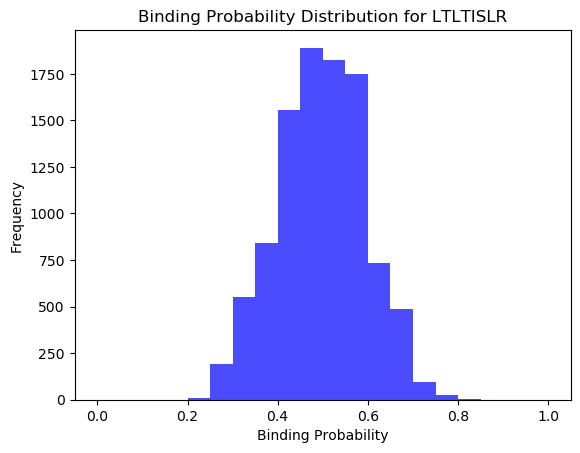

In [45]:
prob_threshold = 0.8 #threshold for high binding
promiscuity_cutoff = 5 #threshold for number of targets needed to be considered promiscuous

promiscuity_counts = (
    predictions_df[predictions_df['probability'] >= prob_threshold]
    .groupby('binder')['target']
    .nunique()
    .reset_index(name = 'high_prob_epitope_count')
)
os.makedirs('./threshold_0.5/histograms_rank', exist_ok = True)

for binder in promiscuity_counts['binder']:
    binder_probs = predictions_df[predictions_df['binder'] == binder]['probability']
    plt.figure()
    plt.hist(binder_probs, bins = 20, range = (0, 1), alpha = 0.7, color = 'blue')
    plt.title(f'Binding Probability Distribution for {binder}')
    plt.xlabel('Binding Probability')
    plt.ylabel('Frequency')
    file = os.path.join('./threshold_0.5/0.65_histograms_rank', f'{binder}_binding_probabilities.png')
    plt.savefig(file, dpi= 300, bbox_inches='tight')

## Model Performance Evaluation

The Promiscuity model is evaluated via the following metrics with accompanying scores:

ROC-AUC: \
AUPRC: \
R2: \
RMSE: 

SHAP analysis was also conducted to analyse feature importance. \
Learning curves compare the different models within the architecture.

In [66]:
print(f"Train R²: {r2:.4f}, Train RMSE: {rmse:.4f}")
print(f"CV R²: {np.mean(cross_val_r2):.4f}, CV RMSE: {np.mean(cross_val_rmse):.4f}")

Train R²: 0.6648, Train RMSE: 35.7783
CV R²: -0.2633, CV RMSE: 63.6968


In [ ]:
y_pred_prob = model.predict_proba(X_scaled)[:,1]
y_pred_class = model.predict(X_scaled)
y_bin = (y > 0).astype(int)
y_filtered_reg_train = np.array([y_train[i] for i in positive_i])

auroc = roc_auc_score(y_bin, y_pred_prob)
auprc = average_precision_score(y_bin, y_pred_prob)
report = classification_report(y_bin, y_pred_class)
cm = confusion_matrix(y_bin, y_pred_class)

print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(report)

y_pred_reg = reg.predict(X_filtered_reg_train)
r2 = r2_score(y_filtered_reg_train, y_pred_reg)
rmse_scorer = make_scorer(mean_squared_error, squared=False)
cross_val_r2 = cross_val_score(reg, X_filtered_reg_train, y_filtered_reg_train, cv = 5, scoring = 'r2')
rmse = mean_squared_error(y_filtered_reg_train, y_pred_reg, squared = False)
cross_val_rmse = cross_val_score(reg, X_filtered_reg_train, y_filtered_reg_train, cv = 5, scoring = rmse_scorer)
print("CV R2:", np.mean(cross_val_r2))
print("CV RMSE:", np.mean(cross_val_rmse))
print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(report)
print(f'Regressor R2: {r2:.4f}, RMSE: {rmse:.4f}')


AUROC: 0.9853
AUPRC: 0.9855
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      5000
           1       0.92      0.92      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

CV R2: -0.2632911814521866
CV RMSE: 63.69683077055627
AUROC: 0.9853
AUPRC: 0.9855
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      5000
           1       0.92      0.92      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Regressor R2: 0.6648, RMSE: 35.7783


In [69]:
y_pred_reg = reg.predict(X_filtered_reg_train)
y_pred_reg_clipped = np.clip(y_pred_reg, 0, 8)
rmse_clipped = mean_squared_error(y_filtered_reg_train, y_pred_reg_clipped, squared = False)
r2_clipped = r2_score(y_filtered_reg_train, y_pred_reg_clipped)
rmse_norm = rmse / (y_filtered_reg_train.max() - y_filtered_reg_train.min())
print(f"Normalised RMSE: {rmse_norm:.4f}")

print(f"Clipped R²: {r2_clipped:.4f}, Clipped RMSE: {rmse_clipped:.4f}")

Normalised RMSE: 0.0135
Clipped R²: -0.0232, Clipped RMSE: 62.5058
